## Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

🔑 **Note**: ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![typesOfTimeSeriesProblems.png](Images/typesOfTimeSeriesProblems.png)

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

### Are you ready?

We've got a lot to go through.

* Get time series data (the historical price of Bitcoin)
    * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

#### Why these dates?

Because **01 October 2013** is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and **18 May 2021** is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

📖 **Resource**: To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV".

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-12-16 10:43:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-12-16 10:44:00 (14.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in `CSV (comma separated values)` format (a very common data format for time series), we'll use the pandas `read_csv()` function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column (`"Date"`).

In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

![bitpriceintro.png](Images/bitpriceintro.png)

🔑 Note: The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see Forecasting: [Principles and Practice Chapter 2.3.](https://otexts.com/fpp3/tspatterns.html)

![typesOfTimeSeries.png](Images/typesOfTimeSeries.png)

*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [6]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

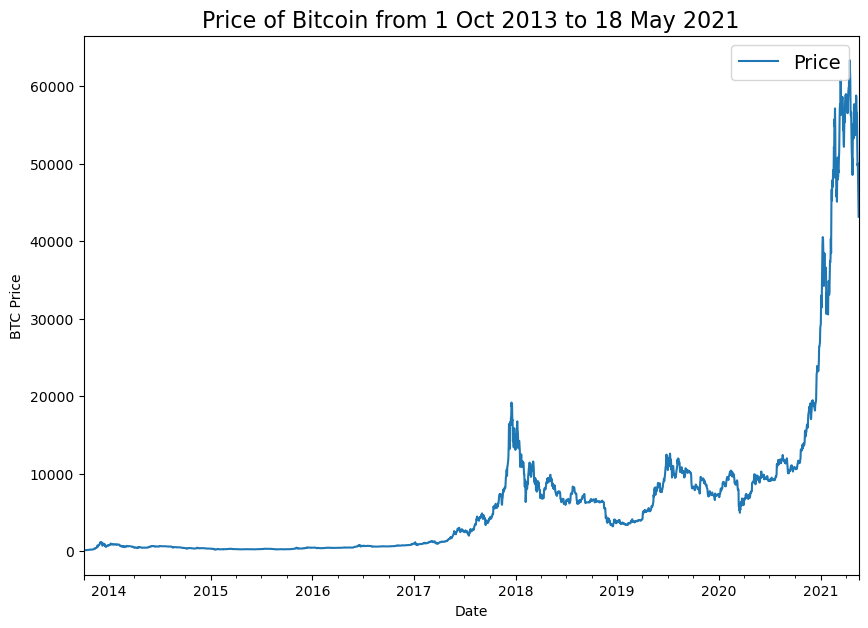

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

## Importing time series data with Python's CSV module

If your time series data comes in `CSV` form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's `datetime`.

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

📖 **Resource**: For a great guide on using Python's `csv` module, check out [Real Python's tutorial on Reading and Writing `CSV` files in Python](https://realpython.com/python-csv/).

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2])) # get the closing price as float
        
# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Beautiful! Now, let's see how things look.

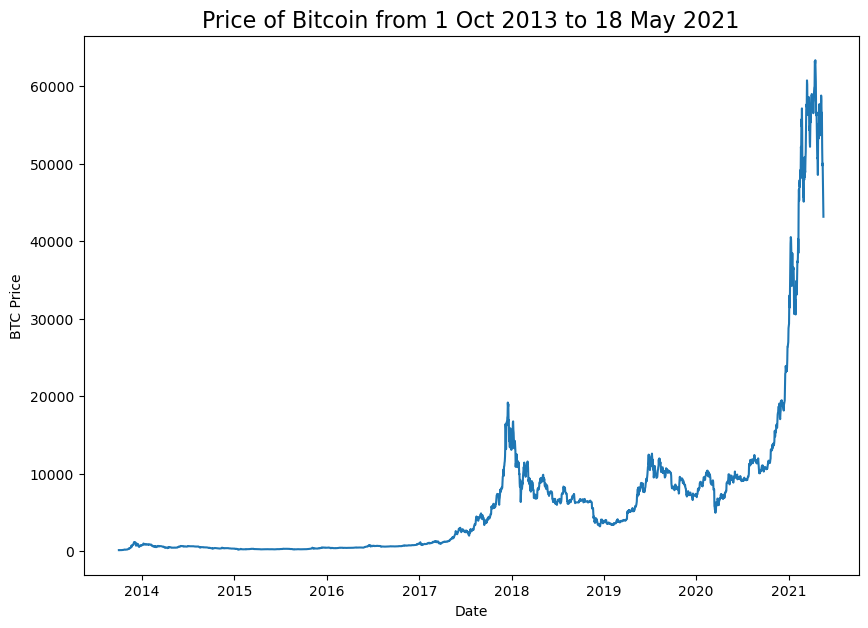

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that! Just like the pandas plot. And because we formatted the timesteps to be datetime objects, matplotlib displays a fantastic looking date axis.

## Format Data Part 1: Creatining train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes!

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding `train_test_split()` but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what kind of data we have.

In time series problems, you'll either have `univariate` or `multivariate` data.

Can you guess what our data is?

* `Univariate time series data` deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* `Multivariate time series data` deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![univariateAndMultivariate.png](Images/univariateAndMultivariate.png)

## Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

How about we first see the wrong way for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [11]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

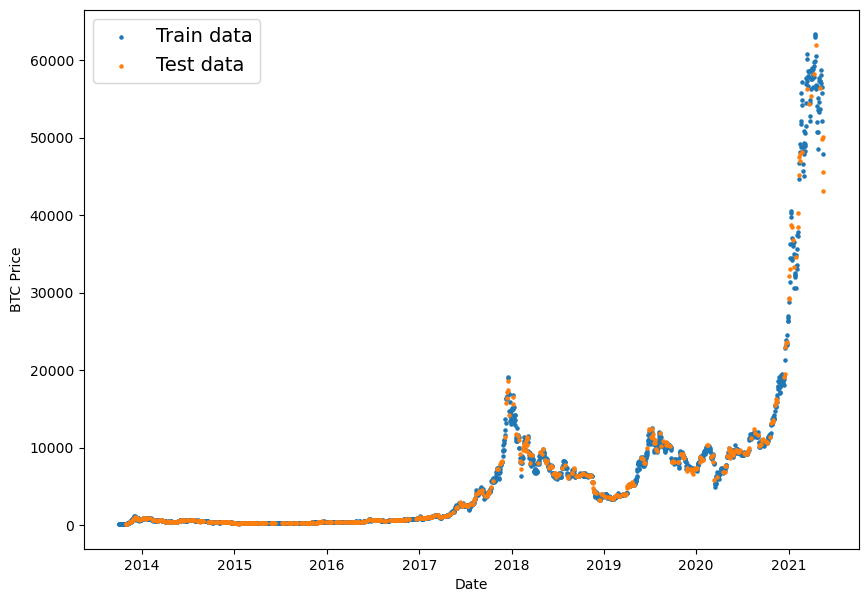

In [12]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Hmmm... what's wrong with this plot?

Well, let's remind ourselves of what we're trying to do.

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin.

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future.

Does the plot above reflect this?

No.

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

## Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![trainAndtestSplit.png](Images/trainAndtestSplit.png)

In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

Okay, looks like our custom made splits are the same lengths as the splits we made with `train_test_split`.

But again, these are numbers on a page.

And you know how the saying goes, trust one eye more than two ears.

Let's visualize.

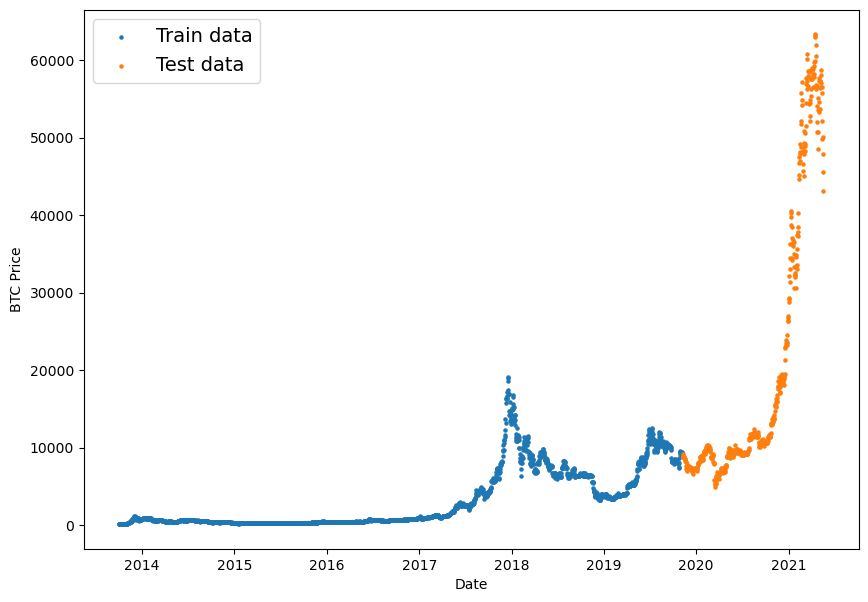

In [14]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

Do you see what's happened here?

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an artificial future, we can guage how our model might perform on actual future data.

    🔑 **Note**: The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing.

    📖 **Resource**: Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [3 facts about time series forecasting](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) that surprise experienced machine learning practitioners talks about different things to watch out for when working with time series data, I'd recommend reading it.

## Create a plotting function

Rather than retyping matplotlib commands to continuously plot data, let's make a plotting function we can reuse later.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

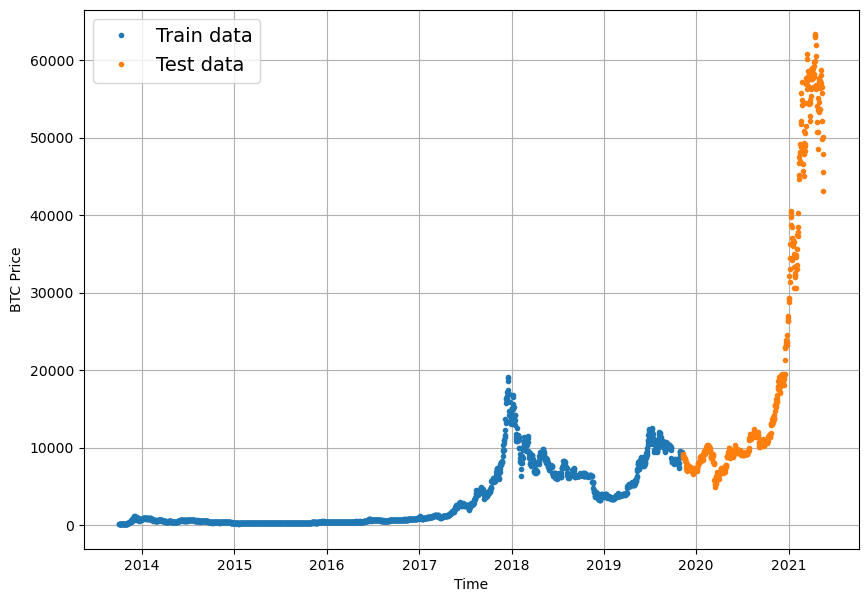

In [16]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Looking good!

Time for some modelling experiments.

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we can build almost any kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

![models4bitprice.png](Images/models4bitprice.png)

🔑 Note: To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed.

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the [naïve model](https://otexts.com/fpp3/simple-methods.html#naïve-method) (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

y^t = yt−1

In English:

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with any kind of model is quite hard.

🔑 Note: For the sake of this notebook, an open system is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a closed system the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in open systems is generally quite poor.

In [17]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

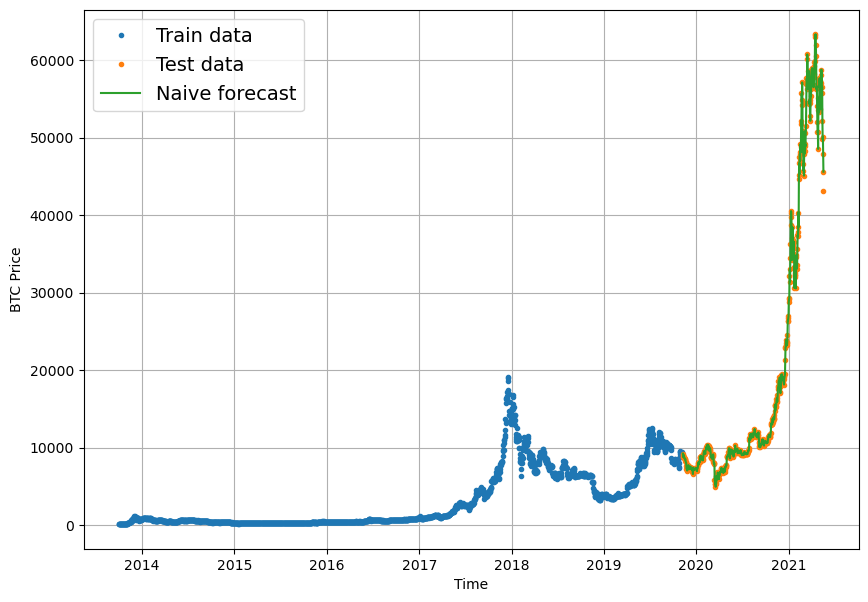

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an `offset` value and passing it to the start parameter of our `plot_time_series()` function.

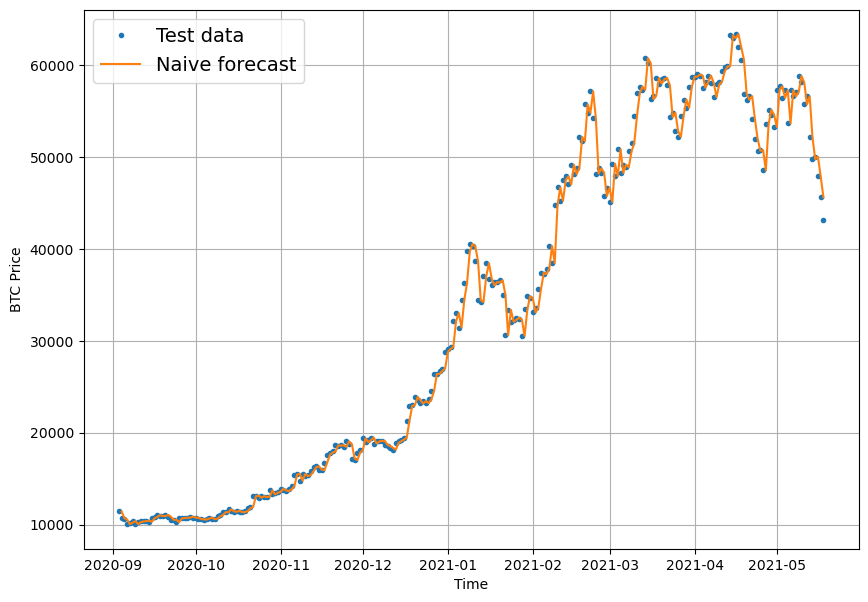

In [19]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And what kind of problem is predicting a number?

Ten points if you said regression.

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or ground truth values)?

📖 **Resource**: We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, lower is better (for example an MAE of 0 is better than an MAE 100).

![errorsTimeSeries.png](Images/errorsTimeSeries.png)

In [20]:
# Let's get TensorFlow! 
import tensorflow as tf

Init Plugin
Init Graph Optimizer
Init Kernel


And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime) (Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the `MASE`.

In [21]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's mae_loss(). In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [22]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

Metal device set to: Apple M1


2022-12-16 13:15:50.721587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 13:15:50.721844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


{'mae': 567.9803,
 'mse': 1147547.1,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957013}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [24]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:

The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?